In [28]:
import matplotlib
import matplotlib.pyplot as plt
import scipy

import astropy.units as u
from astropy.coordinates import AltAz
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time

import numpy as np

from ctapipe.io import event_source
from ctapipe.calib import CameraCalibrator

from ctapipe.coordinates import GroundFrame, TiltedGroundFrame
from ctapipe.image import tailcuts_clean, dilate
from ctapipe.reco.ImPACT import ImPACTReconstructor, guess_shower_depth

from ctapipe.image import hillas_parameters, HillasParameterizationError

from ctapipe.reco import HillasReconstructor
from ctapipe.reco.energy_regressor import EnergyRegressor
from ctapipe.io.containers import ReconstructedShowerContainer, ReconstructedEnergyContainer

from ctapipe.visualization import CameraDisplay

from astropy.table import Table
import copy


In [2]:
%load_ext autoreload
%autoreload 2
from CREED_VTK import CREED_VTK
from ctapipe.reco import HillasReconstructor

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
class HillasNotFinite(Exception):
    """
    Error to be raised when hillas parameters are not finite
    """ 
    pass

def reconstruction(event):
    location = EarthLocation.of_site('Roque de los Muchachos')
    obstime = Time('2018-11-01T02:00')

    horizon_frame = AltAz(location=location, obstime=obstime)
    telescope_pointings = {}
    
    
    features = {}
    hillas_dict = {}
    pointing_azimuth = {}
    pointing_altitude = {}

    cleaned_dict = {}
    array_pointing = SkyCoord(
        az=event.mc.az,
        alt=event.mc.alt,
        frame=AltAz()
    )
    
    for tel_id in event.r0.tels_with_data:
        telescope_pointings[tel_id] = SkyCoord(
            alt=event.mc.tel[tel_id].altitude_raw * u.rad,
            az=event.mc.tel[tel_id].azimuth_raw * u.rad,
            frame=horizon_frame
        )

        dl1 = event.dl1.tel[tel_id]
        camera = event.inst.subarray.tels[tel_id].camera
        mask = tailcuts_clean(camera, dl1.image, 
                              boundary_thresh=4, 
                              picture_thresh=8, 
                              min_number_picture_neighbors=2)
        telescope_type_name = event.inst.subarray.tels[tel_id].optics
        #dl1.cleaned = copy.deepcopy(dl1.image[0])
        cleaned = copy.deepcopy(dl1.image)
        # cleaned = dl1.cleaned
        cleaned[~mask] = 0
        
        if cleaned.sum() > 0:
            try:
                h = hillas_parameters(camera,
                                      cleaned)
                if not all(map(np.isfinite, h.values())):
                    raise HillasNotFinite("bad Hillas parameters")
                    
                hillas_dict[tel_id] = h
                cleaned_dict[tel_id] = cleaned
            except HillasNotFinite:
                pass
        else:
            pass

    if len(hillas_dict) < 2:
        print("mono")
        reconstruction = None
    else:
        # reconstruction, hillas_planes, correct_angle_hillas = hillas_reco.predict(hillas_dict, event.inst, array_pointing, telescopes_pointings=telescope_pointings)
        reconstruction = hillas_reco.predict(hillas_dict, event.inst, array_pointing, telescopes_pointings=telescope_pointings)
    return reconstruction, hillas_dict, cleaned_dict

In [58]:
pwd = "/home/thomas/Programs/astro/CTAPIPE_DAN/"

#filename= "Data/gamma_20deg_180deg_run100___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"
filename= "/home/thomas/Programs/astro/CTAPIPE_DAN/Data/gamma_20deg_0deg_run101___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz"
#filename= "/home/thomas/Programs/astro/CTAPIPE_DAN/Data/gamma_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz"
# filename= "/home/thomas/Programs/astro/Divergent/Data/gamma_20deg_180deg_run10___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz"

# North
# layout = np.loadtxt(pwd+'Utils/CTA.prod3Nb.3AL4-BN15.lis', usecols=0, dtype=int)
# FlashCam
# layout = np.loadtxt(pwd+'CTA.prod3Sb.3HB9-FG.lis', usecols=0, dtype=int)

# NectarCam
# layout = np.loadtxt(pwd+'CTA.prod3Sb.3HB9-NG.lis', usecols=0, dtype=int)

if "Paranal" in filename:
    layout = [4, 5, 6, 11]
    print("PARANAL WITH {0}".format(layout))
elif "palma" in filename:
    # layout = [5, 6, 7, 8]
    layout = np.loadtxt(pwd+'Utils/CTA.prod3Nb.3AL4-BN15.lis', usecols=0, dtype=int)
    layout = set(layout)
    print("LAPALMA WITH {0}".format(layout))

# SELECT ONLY THE MSTs
# layout = list(np.arange(5,20,1))
# layout = [5,6,7,8]
# # layout = [1,2,3,4]
# if "Paranal" in filename:
#     layout = [4, 5, 6, 11]
#     print("PARANAL WITH {0}".format(layout))
# elif "palma" in filename:
#     layout = [5, 6, 7, 8]
#     print("LAPALMA WITH {0}".format(layout))

source = event_source(filename)
source.max_events = 2
source.allowed_tels = layout
events = [copy.deepcopy(event) for event in source]

LAPALMA WITH {64, 65, 67, 68, 5, 6, 7, 8, 72, 74, 75, 76, 117, 58, 59, 60, 61, 62, 63}


In [56]:
#!more /home/thomas/Programs/astro/CTAPIPE_DAN/Utils/Utils/CT

In [59]:
# Calibration
calibrator = CameraCalibrator()
for event in events:
    calibrator(event)

In [60]:
for counter, event in enumerate(events):
    if len(event.r0.tels_with_data) > 1:
        # event = events[10]
        print(counter, event.count, event.mc.energy, event.r0.tels_with_data)

0 0 0.08440064638853073 TeV {5, 6, 7, 8, 72, 62, 63}
1 1 0.011958200484514236 TeV {8, 5, 7}


In [39]:
## Find "big" event
#events_amplitude = []
#for event in events:
#    event_amplitude = 0
#    for tel_id in event.r0.tels_with_data:
#        if event.dl1.tel[tel_id].image is not None:
#            event_amplitude += event.dl1.tel[tel_id].image[0].sum()
#    events_amplitude.append(event_amplitude)
#events_amplitude = np.array(events_amplitude)
#
#mm = events_amplitude.argmax()

#print(mm)
event = events[1]

# Hillas reconstruction
cleaning_level = {
    'ASTRICam': (5, 7, 2),  # (5, 10)?
    'LSTCam': (3.5, 7.5, 2),  # ?? (3, 6) for Abelardo...
    'FlashCam': (4, 8, 2),  # there is some scaling missing?
}

reco = HillasReconstructor()

print('Id: {}, E = {:1.3f}, Telescopes: {}'.format(event.count, event.mc.energy, len(event.r0.tels_with_data)))

# Hillas reconstruction
hillas_reco = HillasReconstructor()
reco, hillas_dict, cleaned_dict = reconstruction(event)

Id: 7, E = 0.023 TeV, Telescopes: 3


In [ ]:
# event.r0.tels_with_data
# 
# print(event.mc.tel[37].azimuth_raw)
# print(event.mc.tel[37].altitude_raw*180/np.pi)
# event.mc.tel[37]
# 
# event.inst.subarray.optics_types
# 
# info = {'CHEC': [],
#         'ASTRICam': [],
#         'LSTCam': [],
#         'FlashCam': [],
#         'DigiCam': [],
#         'NectarCam': [],
#         'SCTCam': [],
#        }
# 
# 
# list(info.keys())
# info
# from astropy.io import ascii
# ascii.write(info, names=list(info.keys()), output="file.dat")
# event = events[4]
# for tel_id in event.r0.tels_with_data:
#     telescope = event.inst.subarray.tel[tel_id]
#     #info[telescope.camera.cam_id] = [telescope.camera.pix_x, telescope.camera.pix_y ]
#     print("{0};   \t{1}    \t  {2} ".format(telescope.optics.identifier[0], telescope.camera.cam_id, telescope.camera.pix_x.shape))
#     

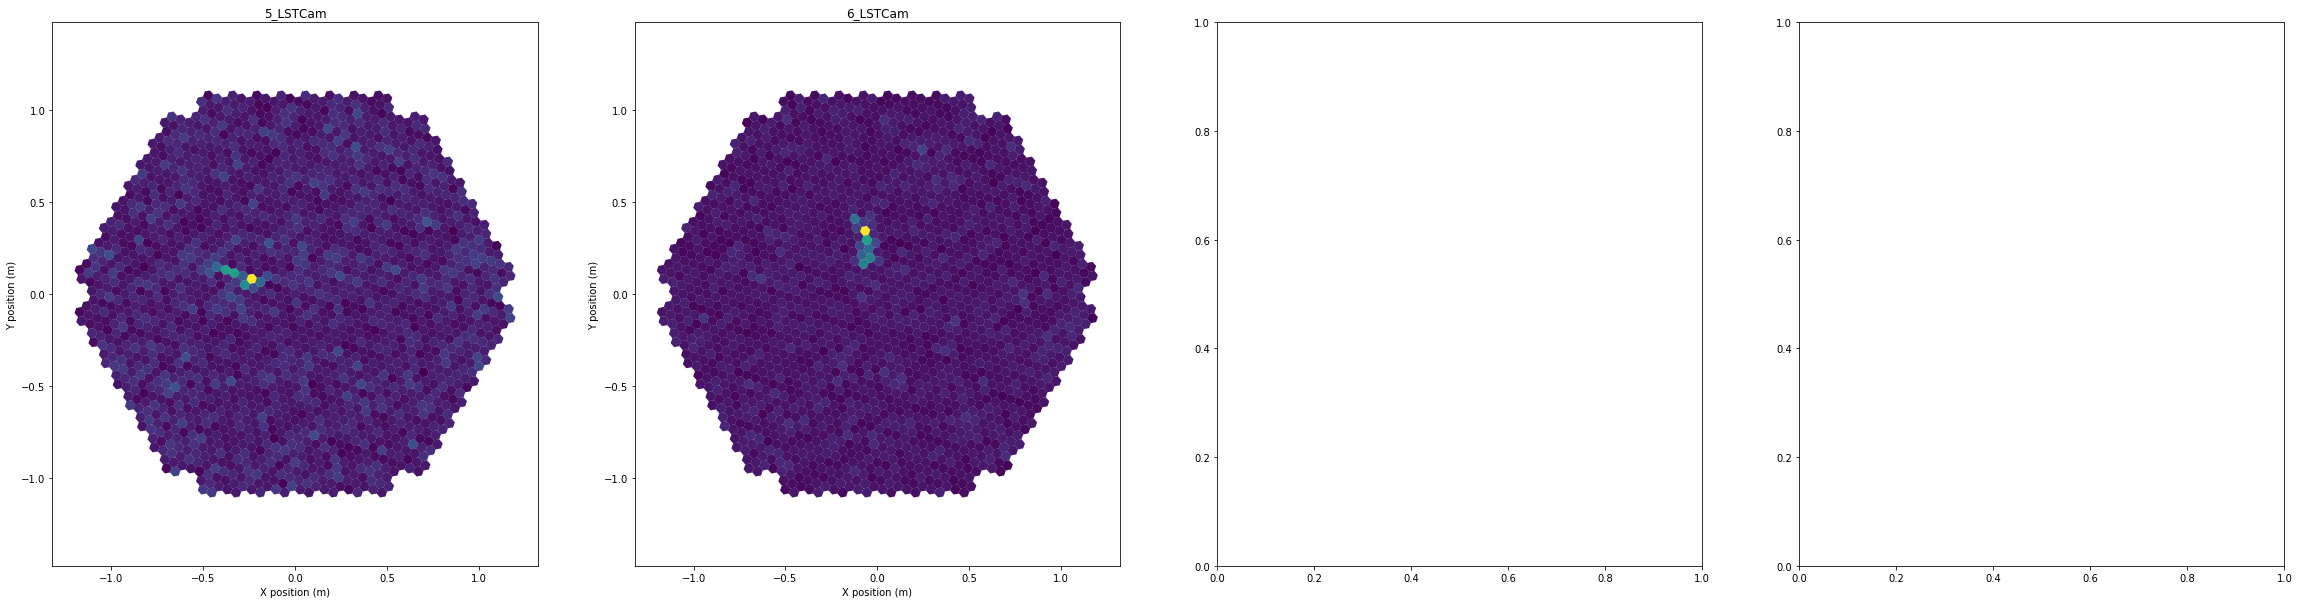

In [51]:
ncol = 4
nrow = len(event.r0.tels_with_data)//ncol + 1 * (len(event.r0.tels_with_data)%ncol > 0)
fs = 10

fig, axes = plt.subplots(nrow, ncol, figsize=(fs*ncol, fs*nrow))

#hillas_dict = {}
#cleaned_dict = {}

for ii, tel_id in enumerate(hillas_dict.keys()):
    camera = event.inst.subarray.tel[tel_id].camera
    image = event.dl1.tel[tel_id].image
    cleaned = cleaned_dict[tel_id]
    disp = CameraDisplay(camera, image, ax = axes.ravel()[ii])
    disp.axes.set_title("{0}_{1}".format(str(tel_id), disp.geom.cam_id))

    cleaned_dict[tel_id] = cleaned
        
    if cleaned.sum() > 0:
        hillas = hillas_parameters(camera, cleaned)
        hillas_dict[tel_id] = hillas
        #disp = CameraDisplay(camera, cleaned, ax=axes.ravel()[ii])
        #disp.overlay_moments(hillas, color='RED', linewidth=3, zorder=10)
plt.show()

In [ ]:
arr_point = SkyCoord(
    alt=event.mcheader.run_array_direction[1], 
    az=event.mcheader.run_array_direction[0], 
    frame=AltAz()
)

In [ ]:
arr_point.az.value

In [ ]:
layout

In [67]:
#render = CREED_VTK(event, telescopes_ids=list(hillas_dict.keys()))
render = CREED_VTK(event, telescopes_ids=list(layout))
# render.event_type(clean_level = "None")
# render.event_type(clean_level = "clean", clean_dict=cleaned_dict)
#render.add_arrows_camera_frame()
render.add_gnd_tels()
render.add_gnd_frame(size=1000)
render.add_tilted_frame(size=1000)
render.add_tilted_tels()
render.camera_view(elev=20)
render.tel_labels()
# render.add_impact_point(label="X mc", status="mc", frame="ground")
#render.add_impact_point(label="X mc", status="mc", frame="ground")

#gnd_reco_pos = GroundFrame(x= reco.core_x, y = reco.core_y, z = 0 * u.m)

# render.add_impact_point(reco.core_x.value, reco.core_y.value, label="+ reco")
# render.add_impact_point(label="+ reco", gnd_reco_pos=gnd_reco_pos)

#render.add_impact_point(status="reco", label="+ reco", gnd_reco_pos=gnd_reco_pos, frame="ground")
#render.plot_hillas_lines(hillas_dict=hillas_dict, length=500, frame="ground")

render.show(width= 1600, height=1000)

In [ ]:
print(hillas_planes.keys())
tel_id = 5
tel_id_2 = 6
print(hillas_planes[tel_id].a, hillas_planes[tel_id].b, hillas_planes[tel_id].c, hillas_planes[tel_id].norm, hillas_planes[tel_id].weight, hillas_planes[tel_id].pos)
print(hillas_planes[tel_id_2].a, hillas_planes[tel_id_2].b, hillas_planes[tel_id_2].c, hillas_planes[tel_id_2].norm, hillas_planes[tel_id_2].weight, hillas_planes[tel_id_2].pos)

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

# plt3d = plt.figure(figsize=(10,10)).gca(projection='3d')

fig = plt.figure(figsize=(10, 10))  
plt3d = fig.add_subplot(111, projection='3d')  

colors = ['r', 'g', 'blue', 'yellow']
names = ['a', 'b', 'c', 'norm']

tels_list = [60, 62]
for tel_id in tels_list: #hillas_planes.keys():
    point  = hillas_planes[tel_id].c
    normal = hillas_planes[tel_id].norm

    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -point.dot(normal)

    # create x,y
    xx, yy = np.meshgrid(np.linspace(-1, 1, 2), np.linspace(-1, 1, 2))

    # calculate corresponding z
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]
    
    # plot the surface
    plt3d.plot_surface(xx, yy, z, alpha = 0.2)

    for i, point in enumerate([hillas_planes[tel_id].a, hillas_planes[tel_id].b, hillas_planes[tel_id].c, hillas_planes[tel_id].norm]):
        color_choosen = colors[i]
        x_pos = point[0]/(np.linalg.norm(point))
        y_pos = point[1]/(np.linalg.norm(point))
        z_pos = point[2]/(np.linalg.norm(point))
        plt3d.quiver(0, 0, 0, point[0], point[1], point[2], normalize=True, color = color_choosen, arrow_length_ratio=0.2)
        plt3d.scatter(
            xs = x_pos, 
            ys = y_pos, 
            zs = z_pos, 
            s = 50, 
            c = color_choosen
        )
        plt3d.text(x_pos, y_pos, z_pos, '%s' % names[i]+" "+ str(tel_id), size=20, zorder=1,   color='k') 



plt3d.scatter(0,0,0, marker="P", s=100, c = "magenta")

u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 30)
x = 1* np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
plt3d.plot_surface(x, y, z, color='b', alpha = 0.1)

plt3d.set_xlim((-1, 1))
plt3d.set_ylim((-1, 1))
plt3d.set_zlim((-1, 1))

plt.show()